# Utilización de la HEMI en Julia

En este cuaderno exploramos las primeras características de la HEMI en el grandioso lenguaje de programación Julia. 

In [1]:
pwd() 

"c:\\Users\\Lenovo\\Documents\\Julia\\HEMI\\notebooks"

In [2]:
using DrWatson
@quickactivate "HEMI"

## Carga de datos

Vamos a cargar los datos del IPC de Guatemala

In [4]:
using HEMI 

In [7]:
gt00, gt10 

(VarCPIBase{Float32, Float32}: 120 períodos × 218 gastos básicos Jan-2001-Dec-2010, VarCPIBase{Float32, Float32}: 122 períodos × 279 gastos básicos Jan-2011-Feb-2021)

Los datos están guardados en estructuras de tipo `VarCPIBase`, que almacenan: 
- las matrices de variaciones intermensuales, 
- los vectores de ponderaciones, 
- las fechas asociadas a la base,
- los índices base. 

In [8]:
gt00, gt10

(VarCPIBase{Float32, Float32}: 120 períodos × 218 gastos básicos Jan-2001-Dec-2010, VarCPIBase{Float32, Float32}: 122 períodos × 279 gastos básicos Jan-2011-Feb-2021)

Para computar los estimadores de inflación, utilizamos una estructura llamada `UniformCountryStructure <: CountryStructure`:

In [10]:
gtdata

UniformCountryStructure{2, Float32, Float32} con 2 bases
|─> VarCPIBase{Float32, Float32}: 120 períodos × 218 gastos básicos Jan-2001-Dec-2010
|─> VarCPIBase{Float32, Float32}: 122 períodos × 279 gastos básicos Jan-2011-Feb-2021


### Seleccionar períodos específicos

Podemos seleccionar períodos específicos para llevar a cabo el cómputo de inflación con una operación de indexado más intuitiva.

In [11]:
gtdata[Date(2020,12)]

UniformCountryStructure{2, Float32, Float32} con 2 bases
|─> VarCPIBase{Float32, Float32}: 120 períodos × 218 gastos básicos Jan-2001-Dec-2010
|─> VarCPIBase{Float32, Float32}: 120 períodos × 279 gastos básicos Jan-2011-Dec-2020


Para obtener una base del IPC en la estructura, indexamos por enteros: 

In [13]:
gtdata[1]

VarCPIBase{Float32, Float32}: 120 períodos × 218 gastos básicos Jan-2001-Dec-2010

### Agregar una base del IPC

Supongamos ahora que tenemos una nueva base ficticia del IPC con 300 gastos básicos con base en diciembre de 2022. 

In [16]:
# Creamos algunos datos ficticios
v22 = randn(Float32, 60, 300)
w22 = rand(Float32, 300)
gt22 = VarCPIBase(v22, w22, Date(2023,1):Month(1):Date(2027,12), 100f0)

VarCPIBase{Float32, Float32}: 60 períodos × 300 gastos básicos Jan-2023-Dec-2027

In [17]:
gtnewdata = UniformCountryStructure(gt00, gt10, gt22)

UniformCountryStructure{3, Float32, Float32} con 3 bases
|─> VarCPIBase{Float32, Float32}: 120 períodos × 218 gastos básicos Jan-2001-Dec-2010
|─> VarCPIBase{Float32, Float32}: 122 períodos × 279 gastos básicos Jan-2011-Feb-2021
|─> VarCPIBase{Float32, Float32}: 60 períodos × 300 gastos básicos Jan-2023-Dec-2027


## Cómputo de estimadores de inflación

La librería base incluye la variación interanual del IPC como función más básica de inflación. Para poder aplicarla, la instanciamos como un objeto. 

In [18]:
totalfn = InflationTotalCPI()

(::InflationTotalCPI) (generic function with 6 methods)

La ventaja de esta implementación es que la función de inflación puede embeber sus parámetros y datos. Por ejemplo, las funciones de inflación se crean con su nombre. Esto puede parecer una característica no tan útil, pero en realidad, cuando se itera hacia arriba en la evaluación, se deben acarrear dichos parámetros en muchos lugares del código. Es una mejor práctica **embeberlos**. 

In [20]:
measure_name(totalfn)

"Variación interanual IPC"

Para aplicarla, simplemente se debe llamar sobre un objeto `CountryStructure`: 

In [25]:
totalfn(gtdata)

231-element Vector{Float32}:
 8.719707
 8.6865425
 8.902157
 9.005642
 9.147131
 9.226524
 9.102488
 9.139276
 7.7949524
 7.197356
 6.6627264
 6.5288544
 6.5147996
 ⋮
 1.7696381
 1.8787146
 1.8027067
 2.388215
 2.8786063
 4.194188
 4.9636245
 5.34544
 5.4622054
 4.829943
 5.2387714
 5.999708

Algo además muy útil es el "despacho múltiple" (***multiple dispatch***) de Julia: llamamos a la misma función, con diferentes argumentos y aplica una metodología diferente. Por ejemplo, si en vez de la variación interanual, quisiéramos el índice de precios de la medida de inflación, hacemos: 

In [33]:
totalfn(gtdata, CPIIndex())

242-element Vector{Float64}:
 101.34643426260612
 102.0712127314407
 102.59958556121363
 103.0182346550822
 103.3107549626403
 104.0298370639817
 104.863711021611
 106.15126773990929
 106.48331580207778
 107.33251061697221
 108.09200732044398
 108.7196731206405
 110.14990540185048
   ⋮
 272.15501177869504
 274.0925480240522
 274.6134386795303
 278.4846185836708
 279.66526781720705
 280.78044994852155
 281.21080336802044
 284.19475256207323
 285.7733649444347
 285.75922452029135
 286.1850663814757
 287.1044415052746

O la variación intermensual: 

In [26]:
totalfn(gtdata, CPIVarInterm())

242-element Vector{Float32}:
  1.3464332
  0.71516037
  0.5176425
  0.4080534
  0.28395653
  0.6960273
  0.8015871
  1.2278318
  0.31279325
  0.79751015
  0.7075906
  0.5806923
  1.3155222
  ⋮
  0.4803419
  0.7119298
  0.19003153
  1.4096856
  0.42395592
  0.39875507
  0.15326738
  1.0610938
  0.5554795
 -0.0049471855
  0.1490593
  0.3211975

Al principio, es un poco extraño llamar a la misma función con otros argumentos, pero en realidad, es un patrón común en computación científica. En la HEMI este patrón simplifica muchas cosas en el código. Esto es porque Julia funciona con sistema de tipos que permite escribir código más genérico. Por ejemplo, veamos el tipo de nuestra función de inflación: 

In [28]:
supertypes(InflationTotalCPI)

(InflationTotalCPI, InflationFunction, Function, Any)

Como vemos, el tipo `InflationTotalCPI` es una `InflationFunction`, pero también deriva de `Function`. Esto nos permite agregar métodos genéricos para cualquier `InflationFunction`: 

In [31]:
methods(totalfn)

# 6 methods:
[1] (inflfn::InflationFunction)(cs::CountryStructure) in CPIDataBase at C:\Users\Lenovo\Documents\Julia\HEMI\src\CPIDataBase\src\inflation\InflationFunction.jl:75
[2] (inflfn::InflationFunction)(cs::CountryStructure, ::CPIVarInterm) in CPIDataBase at C:\Users\Lenovo\Documents\Julia\HEMI\src\CPIDataBase\src\inflation\InflationFunction.jl:86
[3] (inflfn::InflationFunction)(cs::CountryStructure, ::CPIIndex) in CPIDataBase at C:\Users\Lenovo\Documents\Julia\HEMI\src\CPIDataBase\src\inflation\InflationFunction.jl:80
[4] (inflfn::InflationTotalCPI)(base::VarCPIBase{T, T}) where T<:AbstractFloat in CPIDataBase at C:\Users\Lenovo\Documents\Julia\HEMI\src\CPIDataBase\src\inflation\InflationFunction.jl:115
[5] (inflfn::InflationTotalCPI)(base::VarCPIBase{T, B}) where {T<:AbstractFloat, B<:AbstractVector{T}} in CPIDataBase at C:\Users\Lenovo\Documents\Julia\HEMI\src\CPIDataBase\src\inflation\InflationFunction.jl:126
[6] (inflfn::InflationFunction)(::VarCPIBase) in CPIDataBase at C:\Users\Lenovo\Documents\Julia\HEMI\src\CPIDataBase\src\inflation\InflationFunction.jl:95

### Extendiendo una función de inflación

La forma más simple de ejemplificar los métodos genéricos es extender nuestra función de inflación de media simple. Para que opere, simplemente tenemos que definir cómo debe operar sobre los objetos `VarCPIBase`, que contienen toda la información para computar la medida de inflación (estadística) de una base del IPC: la matriz de variaciones intermensuales y las ponderaciones.

In [37]:
using Statistics

In [32]:
Base.@kwdef struct InflationMean <: InflationFunction
    name::String = "Media simple"
end

    
function (inflfn::InflationMean)(base::VarCPIBase)
    mean(base.v; dims=2)
end

Ahora instanciamos nuestra función y computamos la medida de inflación: 

In [33]:
smeanfn = InflationMean()

(::InflationMean) (generic function with 5 methods)

In [34]:
methods(smeanfn)

# 5 methods:
[1] (inflfn::InflationFunction)(cs::CountryStructure) in CPIDataBase at C:\Users\Lenovo\Documents\Julia\HEMI\src\CPIDataBase\src\inflation\InflationFunction.jl:75
[2] (inflfn::InflationFunction)(cs::CountryStructure, ::CPIVarInterm) in CPIDataBase at C:\Users\Lenovo\Documents\Julia\HEMI\src\CPIDataBase\src\inflation\InflationFunction.jl:86
[3] (inflfn::InflationFunction)(cs::CountryStructure, ::CPIIndex) in CPIDataBase at C:\Users\Lenovo\Documents\Julia\HEMI\src\CPIDataBase\src\inflation\InflationFunction.jl:80
[4] (inflfn::InflationMean)(base::VarCPIBase) in Main at In[32]:6
[5] (inflfn::InflationFunction)(::VarCPIBase) in CPIDataBase at C:\Users\Lenovo\Documents\Julia\HEMI\src\CPIDataBase\src\inflation\InflationFunction.jl:95

Y computamos nuestra medida de inflación: 

In [35]:
smeanfn(gtdata, CPIIndex())

242×1 Matrix{Float32}:
 101.37316
 102.22997
 102.70309
 103.21459
 103.37779
 104.35657
 104.90865
 105.85988
 106.27217
 107.289604
 108.0507
 108.59126
 110.309105
   ⋮
 252.47475
 252.81491
 253.2265
 254.79791
 255.31139
 255.66519
 256.3217
 257.5538
 258.16998
 259.079
 259.69794
 260.51715

El paquete `InflationFunctions`, cargado por el módulo `HEMI` alberga(rá) otras funciones de inflación. 

In [43]:
using InflationFunctions

### Conjuntos y combinaciones

Tenemos la siguiente función de combinación para computar varias medidas de inflación a la vez.

In [37]:
percfn = InflationPercentileEq.(60:85) |> Tuple |> EnsembleFunction

(::EnsembleFunction{26}) (generic function with 5 methods)

In [38]:
percfn(gtdata, CPIVarInterm())

242×26 Matrix{Float32}:
 1.07        1.1122     1.1754     1.19       …  2.3011    2.4528    2.506
 0.674125    0.706689   0.752199   0.764567      1.59622   1.65907   1.68661
 0.408513    0.421583   0.428893   0.456405      1.19056   1.23997   1.27448
 0.27178     0.289703   0.298526   0.318733      0.970116  1.07152   1.18509
 0.263243    0.273525   0.282578   0.296934      0.666706  0.671     0.707696
 0.364099    0.394026   0.415571   0.451913   …  1.20181   1.23759   1.26123
 0.44562     0.461215   0.480141   0.485691      1.04128   1.07501   1.10611
 0.934677    0.947381   0.965702   1.00398       1.88948   1.91935   1.96978
 0.514002    0.52475    0.539286   0.571389      1.05105   1.09259   1.16587
 0.705279    0.716616   0.724996   0.728649      1.17701   1.30023   1.39007
 0.520556    0.553666   0.577255   0.602767   …  1.14805   1.17258   1.21618
 0.406006    0.419903   0.442468   0.461203      1.08103   1.15501   1.25718
 1.2369      1.29541    1.34434    1.36455       3.19

Tenemos la siguiente función de combinación para computar varias medidas de inflación a la vez y combinarlas.

In [39]:
combfn = CombinationFunction(percfn, repeat([1/26], 26))

(::CombinationFunction{26, Vector{Float64}}) (generic function with 6 methods)

In [40]:
combfn(gtdata)

231-element Vector{Float64}:
 11.34380472623385
 11.903379788765543
 12.024603018393885
 11.997757911682129
 12.050973983911371
 12.035496895129864
 11.791389318612906
 11.583950941379255
 10.523738384246826
 10.083759637979362
  9.576842803221483
  9.172336908487173
  8.861493954291712
  ⋮
  2.7457040089827323
  2.6643743881812463
  2.6364528215848484
  2.571739600254939
  2.557912698158851
  2.6061278123122
  2.6973660175616923
  2.7052232852348914
  2.7654294784252462
  2.826487559538621
  2.9252368670243483
  3.104033836951623

## Generación de trayectorias de simulación 

Como vimos en la presentación, la generación de trayectorias en Julia es mucho más rápida. 

In [44]:
using InflationEvalTools
using Plots

In [50]:
gtdata_eval = gtdata[Date(2020,12)]

UniformCountryStructure{2, Float32, Float32} con 2 bases
|─> VarCPIBase{Float32, Float32}: 120 períodos × 218 gastos básicos Jan-2001-Dec-2010
|─> VarCPIBase{Float32, Float32}: 120 períodos × 279 gastos básicos Jan-2011-Dec-2020


In [45]:
resamplefn = ResampleSBB(36)
trendfn = TrendIdentity()

In [51]:
tray_infl = gentrayinfl(totalfn, resamplefn, trendfn, gtdata_eval, K = 10_000); 
size(tray_infl)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


(229, 1, 10000)

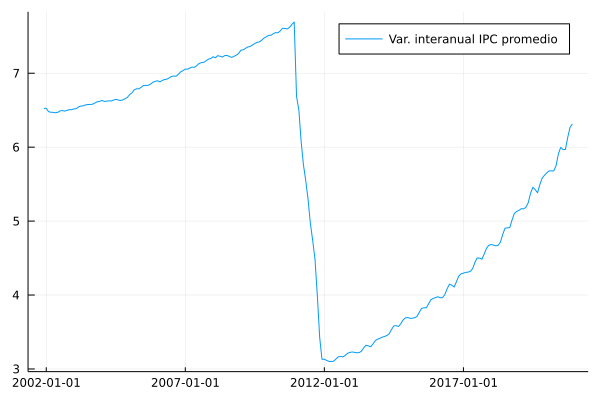

In [52]:
# Promedio a través de las realizaciones
m_tray_infl = vec(mean(tray_infl, dims=3))

plot(infl_dates(gtdata_eval), m_tray_infl, 
    label="Var. interanual IPC promedio") 

## Generación de trayectorias en paralelo

Para generar trayectorias en paralelo utilizamos la librería `Distributed` en cada proceso y la función `pargentrayinfl`.

In [53]:
using Distributed

In [54]:
addprocs(2, exeflags="--project")

2-element Vector{Int64}:
 2
 3

In [55]:
@everywhere using HEMI 

In [56]:
perkfn = InflationPercentileEq(69)

(::InflationPercentileEq) (generic function with 5 methods)

In [57]:
tray_infl = pargentrayinfl(perkfn, resamplefn, trendfn, gtdata_eval; K = 10_000); 
size(tray_infl)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:16


(229, 1, 10000)

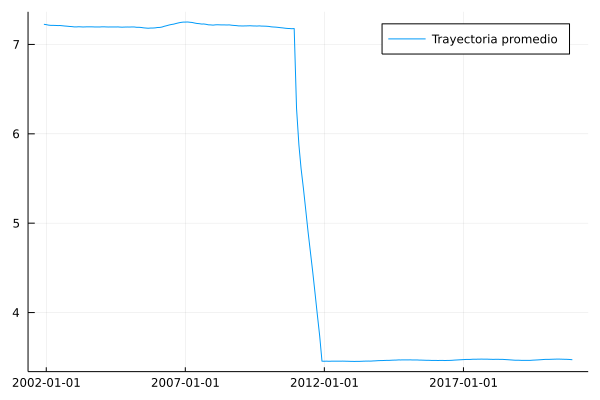

In [60]:
# Promedio a través de las realizaciones
m_tray_infl = vec(mean(tray_infl, dims=3))

plot(infl_dates(gtdata_eval), m_tray_infl, 
    label="Trayectoria promedio") 